In [1]:
import anndata as ad
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
from scipy.stats import kruskal, mannwhitneyu, false_discovery_control
import seaborn as sns

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/')
from clinical import load_clinical
from data_processing import *
from spatial import *

In [2]:
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/hdf5_codex_final_stromal_phenotypes_inc_unclassifiable.h5ad')

/mnt/cephfs/home/users/krakovic/.conda/envs/scpy/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adata_df = sc.get.obs_df(adata=adata, keys=['CellX', 'CellY', 'TMA', 'core_ID', 'samples', 'concat_phenotype', 'text_phenotype', 'final_phenotype'])
adata_df['final_phenotype'] = adata_df['final_phenotype'].fillna('Unclassifiable')
adata_df

,CellX,CellY,TMA,core_ID,samples,concat_phenotype,text_phenotype,final_phenotype
0,2396.8,6263.1,12,12-15-J,ACA_0662,Stroma_nan,NaN,Unclassifiable
1,2420.0,6264.4,12,12-15-J,ACA_0662,Tumour,NaN,Tumour
2,2428.9,6265.5,12,12-15-J,ACA_0662,Tumour,NaN,Tumour
3,2409.4,6267.8,12,12-15-J,ACA_0662,Tumour,NaN,Tumour
4,2474.5,6266.5,12,12-15-J,ACA_0662,Negative/unclassifiable,NaN,Unclassifiable
...,...,...,...,...,...,...,...,...
2670918,17607.6,20332.7,22,22-15-J,ACA_1069,Immune_CD45+ CD4+,NaN,CD4+
2670919,17733.6,20460.9,22,22-15-J,ACA_1069,Immune_CD45+ CD20+,NaN,CD20+
2670920,17500.8,20961.7,22,22-15-J,ACA_1069,Stroma_4,$DCN_{high}COL1A_{med}$,$DCN_{high}COL1A_{med}$
2670921,17685.7,20402.6,22,22-15-J,ACA_1069,Immune_CD45+ CD20+,NaN,CD20+


In [ ]:
adata_df['core_ID'].nunique()

436

In [ ]:
# pure_clusters_frame = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/geomx_gs/joint_bioclavis_gs_for_codex_HD_by_hazard_ratio.csv', index_col=0)
pure_clusters_frame = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/codex_pure_superclusters_split_HPC13.csv', index_col=0)
pure_clusters_frame = pure_clusters_frame.replace({'cold_cohesive':'Cold, cohesive', 'cold_discohesive':'Cold, discohesive', 'hot_cohesive':'Hot, cohesive', 'hot_discohesive':'Hot, discohesive'})
pure_clusters_frame

,core_ID,supercluster,cluster,consensus_HD_equal,consensus_HD_more
0,12-02-A,"Cold, discohesive",HPC 27,1,0
1,12-02-B,"Hot, cohesive",HPC 0,1,0
2,12-02-C,"Hot, cohesive",HPC 67,1,0
3,12-02-D,"Hot, discohesive",HPC 10,0,0
4,12-02-F,"Cold, cohesive",NaN,1,0
...,...,...,...,...,...
221,22-14-A,"Cold, discohesive",HPC 31,1,0
222,22-14-G,"Cold, cohesive",HPC 68,1,0
223,22-14-H,"Hot, discohesive",HPC 28,0,0
224,22-15-A,"Hot, cohesive",HPC 50,1,0


In [ ]:
def assign_cohesive_phenotype(row):
    if row['supercluster'] != 'Hot, discohesive':
        return row['supercluster']
    else:
        if row['consensus_HD_equal'] == 1:
            return 'Hot, discohesive (high risk)'
        else:
            return 'Hot, discohesive (low risk)'

pure_clusters_frame['cons_supercluster'] = pure_clusters_frame.apply(lambda row: assign_cohesive_phenotype(row), axis=1)
pure_clusters_frame

,core_ID,supercluster,cluster,consensus_HD_equal,consensus_HD_more,cons_supercluster
0,12-02-A,"Cold, discohesive",HPC 27,1,0,"Cold, discohesive"
1,12-02-B,"Hot, cohesive",HPC 0,1,0,"Hot, cohesive"
2,12-02-C,"Hot, cohesive",HPC 67,1,0,"Hot, cohesive"
3,12-02-D,"Hot, discohesive",HPC 10,0,0,"Hot, discohesive (low risk)"
4,12-02-F,"Cold, cohesive",NaN,1,0,"Cold, cohesive"
...,...,...,...,...,...,...
221,22-14-A,"Cold, discohesive",HPC 31,1,0,"Cold, discohesive"
222,22-14-G,"Cold, cohesive",HPC 68,1,0,"Cold, cohesive"
223,22-14-H,"Hot, discohesive",HPC 28,0,0,"Hot, discohesive (low risk)"
224,22-15-A,"Hot, cohesive",HPC 50,1,0,"Hot, cohesive"


In [ ]:
pure_cores_to_exclude = [
    '12-04-F', '12-05-B', '12-05-C', '12-09-C', '12-13-A',
    '13-06-J', '13-09-G', '13-10-D'
    '21-02-F', '21-04-B', '21-04-F', '21-09-C',
    '22-15-G'
]

other_cores_to_exclude = [
    '12-02-E', '12-02-J', '12-05-B', '12-09-C', '12-10-C', '12-11-C', '12-14-A',
    '13-05-F', '13-06-C', '13-07-J', '13-07-G', '13-10-A', '13-15-C',
    '21-02-B', '21-02-G', '21-03-G', '21-13-H', '21-13-J', '21-14-A', '21-14-H', '21-15-A', '21-15-E', '21-15-H',
    '22-02-A', '22-02-C', '22-02-I', '22-03-A', '22-03-B', '22-03-F', '22-04-A', '22-04-F', '22-05-F', '22-6-E', '22-09-C', '22-10-C', '22-13-I', '23-15-A', '22-15-C', '22-15-F', '22-15-G'
]

all_cores_to_exclude = pure_cores_to_exclude + other_cores_to_exclude

In [8]:
pure_cores_filtered = pure_clusters_frame[~pure_clusters_frame['core_ID'].isin(all_cores_to_exclude)]
pure_cores_filtered

,core_ID,supercluster,cluster,consensus_HD_equal,consensus_HD_more,cons_supercluster
0,12-02-A,"Cold, discohesive",HPC 27,1,0,"Cold, discohesive"
1,12-02-B,"Hot, cohesive",HPC 0,1,0,"Hot, cohesive"
2,12-02-C,"Hot, cohesive",HPC 67,1,0,"Hot, cohesive"
3,12-02-D,"Hot, discohesive",HPC 10,0,0,"Hot, discohesive (low risk)"
4,12-02-F,"Cold, cohesive",NaN,1,0,"Cold, cohesive"
...,...,...,...,...,...,...
221,22-14-A,"Cold, discohesive",HPC 31,1,0,"Cold, discohesive"
222,22-14-G,"Cold, cohesive",HPC 68,1,0,"Cold, cohesive"
223,22-14-H,"Hot, discohesive",HPC 28,0,0,"Hot, discohesive (low risk)"
224,22-15-A,"Hot, cohesive",HPC 50,1,0,"Hot, cohesive"


In [ ]:
pure_cores_filtered['cons_supercluster'].value_counts()

Cold, cohesive                  56
Hot, discohesive (low risk)     51
Hot, cohesive                   47
Cold, discohesive               45
Hot, discohesive (high risk)     8
Name: cons_supercluster, dtype: int64

In [10]:
adata_df = adata_df[~adata_df['core_ID'].isin(all_cores_to_exclude)]

In [11]:
adata_df

,CellX,CellY,TMA,core_ID,samples,concat_phenotype,text_phenotype,final_phenotype
0,2396.8,6263.1,12,12-15-J,ACA_0662,Stroma_nan,NaN,Unclassifiable
1,2420.0,6264.4,12,12-15-J,ACA_0662,Tumour,NaN,Tumour
2,2428.9,6265.5,12,12-15-J,ACA_0662,Tumour,NaN,Tumour
3,2409.4,6267.8,12,12-15-J,ACA_0662,Tumour,NaN,Tumour
4,2474.5,6266.5,12,12-15-J,ACA_0662,Negative/unclassifiable,NaN,Unclassifiable
...,...,...,...,...,...,...,...,...
2670918,17607.6,20332.7,22,22-15-J,ACA_1069,Immune_CD45+ CD4+,NaN,CD4+
2670919,17733.6,20460.9,22,22-15-J,ACA_1069,Immune_CD45+ CD20+,NaN,CD20+
2670920,17500.8,20961.7,22,22-15-J,ACA_1069,Stroma_4,$DCN_{high}COL1A_{med}$,$DCN_{high}COL1A_{med}$
2670921,17685.7,20402.6,22,22-15-J,ACA_1069,Immune_CD45+ CD20+,NaN,CD20+


### Identify discohesive cells

In [ ]:
from sklearn.cluster import DBSCAN

def get_core_noise_prop(core_df, x_col, y_col, phenotype_col, phenotype, eps, min_samples):
    points = core_df[core_df[phenotype_col] == phenotype][[x_col, y_col]].values

    clusters = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=10).fit_predict(points)
    total_cells = clusters.shape[0]
    noise_cells = clusters[clusters == -1].shape[0]
    prop_noise = noise_cells / total_cells

    # Reassign labels -- merge all clusters (comparison is cohesive vs not)
    clusters[clusters != -1] = 1

    return clusters, prop_noise

# get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=15, min_samples=5)

In [13]:
cores = adata_df['core_ID'].unique()
noise_list = list()

for i, core in enumerate(cores):
    core_idx = adata_df.loc[(adata_df['core_ID'] == core) & (adata_df['final_phenotype'] == 'Tumour')].index.values
    clusters, noise = get_core_noise_prop(core_df=adata_df[adata_df['core_ID'] == core], x_col='CellX', y_col='CellY', phenotype_col='final_phenotype', phenotype='Tumour', eps=25, min_samples=5)
    adata_df.loc[core_idx, 'dbscan'] = clusters;
    noise_list.append((core, noise))
    

/tmp/ipykernel_2086736/4216020932.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_df.loc[core_idx, 'dbscan'] = clusters;


In [14]:
noise_df = pd.DataFrame(noise_list, columns=['core_ID', 'noise'])
noise_df = noise_df.merge(pure_clusters_frame[['core_ID', 'cluster', 'supercluster', 'consensus_HD_more']], on='core_ID', how='inner')
noise_df

,core_ID,noise,cluster,supercluster,consensus_HD_more
0,12-15-I,0.673267,NaN,"Hot, discohesive",0
1,12-15-G,0.038313,HPC 44,"Hot, cohesive",0
2,12-15-F,0.958678,NaN,"Cold, discohesive",0
3,12-15-E,0.454768,NaN,"Cold, discohesive",0
4,12-14-I,0.103106,NaN,"Cold, discohesive",0
...,...,...,...,...,...
194,22-14-A,0.262976,HPC 31,"Cold, discohesive",0
195,22-14-G,0.037216,HPC 68,"Cold, cohesive",0
196,22-14-H,0.900000,HPC 28,"Hot, discohesive",0
197,22-15-A,0.028233,HPC 50,"Hot, cohesive",0


In [ ]:
noise_df.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/layered_neighbours_noise_df.csv')

In [16]:
## Alter the phenotypes of tumour cells -- split these into cohesive and discohesive based on DBSCAN results

## Helper function to implement logic

def assign_cohesive_phenotype(row):
    if row['final_phenotype'] != 'Tumour':
        return row['final_phenotype']
    else:
        if row['dbscan'] == -1:
            return 'Discohesive tumour'
        else:
            return 'Cohesive tumour'

adata_df['disco_phenotype'] = adata_df.apply(lambda row: assign_cohesive_phenotype(row), axis=1)

/tmp/ipykernel_2086736/3540594315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_df['disco_phenotype'] = adata_df.apply(lambda row: assign_cohesive_phenotype(row), axis=1)


In [17]:
def neighbourhood_frequency_vector(neighbourhood_phenotypes, all_phenotypes=None):
    if all_phenotypes is None:
        all_phenotypes = set()
        for centroid in neighbourhood_phenotypes:
            all_phenotypes.update(centroid)
    else:
        all_phenotypes = set(all_phenotypes)

    results = list()

    for idx, phenotypes in enumerate(neighbourhood_phenotypes):
        counts = Counter(phenotypes)

        idx_dict = {
            'index':idx,
            'Total_Cells':phenotypes.shape[0]
        }

        for phenotype in all_phenotypes:
            idx_dict[f'{phenotype}'] = counts.get(phenotype, 0)

        results.append(idx_dict)
    
    results_df = pd.DataFrame(results)

    return results_df

def cell_nearest_neighbours(core_df, x_col, y_col, phenotype_col, radius, all_phenotypes=None, k=12, buffer_distance=50):
    coordinates = core_df[[x_col, y_col]].values
    phenotypes = core_df[phenotype_col].values
    idx = core_df.index

    if buffer_distance > 0:
        interior_mask = create_buffer(coordinates, buffer_distance)
        coordinates = coordinates[interior_mask]
        phenotypes = phenotypes[interior_mask]
        idx = idx[interior_mask]

    tree = KDTree(coordinates)
    neighbours = tree.query_ball_point(coordinates, r=radius, workers=k)

    neighbourhood_phenotypes = [phenotypes[res] for res in neighbours]

    results_df = neighbourhood_frequency_vector(neighbourhood_phenotypes=neighbourhood_phenotypes, all_phenotypes=all_phenotypes)
    results_df['orig_idx'] = idx
    results_df['orig_phenotype'] = phenotypes

    return results_df

def enrichment_test_by_phenotype(data, phenotype_cols, meta_col, p_th=0.05):
    results = list()
    overall_avg = data.mean(numeric_only=True, axis=0)
    for group in data[meta_col].unique():
        for phenotype in phenotype_cols:
            positive_group = data[data[meta_col] == group][phenotype].values
            # negative_group = data[data[meta_col] != group][phenotype].values
            negative_group = data[phenotype].values
            statistic, p_value = mannwhitneyu(positive_group, negative_group, alternative='two-sided')
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            log_fc = np.log2((np.mean(positive_group) + 1e-9) / (overall_avg.loc[phenotype] + 1e-9))


            results.append({
                'Supercluster':group,
                'marker':phenotype,
                'l2fc':log_fc,
                'statistic':statistic,
                'p_val': p_value
            })

    results = pd.DataFrame(results)
    results['p_adj'] = false_discovery_control(results['p_val'], method='bh')
    change_data = results.pivot(index='Supercluster', columns='marker', values='l2fc')
    pval_data = results.pivot(index='Supercluster', columns='marker', values='p_adj')

    significant_mask = pval_data < p_th
    annot_text = change_data.applymap('{:.2f}'.format)
    annot_text = annot_text.mask(significant_mask, '*')
    annot_text = annot_text.mask(~significant_mask, ' ')

    return change_data, annot_text

In [18]:
def layered_nearest_neighbours(core_df, x_col, y_col, phenotype_col,
                                         target_phenotype,
                                         count_phenotypes,
                                         radii=[25, 50, 100],
                                         k=12,
                                         buffer_distance=50):
   
    candidate_df = core_df.copy()

    if count_phenotypes is not None:
        candidate_df = candidate_df[candidate_df[phenotype_col].isin(count_phenotypes)]
    
    candidate_coords = candidate_df[[x_col, y_col]].values
    candidate_phenotypes = candidate_df[phenotype_col].values

    if buffer_distance > 0:
        interior_mask = create_buffer(candidate_coords, buffer_distance)
        candidate_coords = candidate_coords[interior_mask]
        candidate_phenotypes = candidate_phenotypes[interior_mask]

    tree = KDTree(candidate_coords)

    target_df = core_df[core_df[phenotype_col] == target_phenotype].copy()
    target_coords = target_df[[x_col, y_col]].values

    if buffer_distance > 0:
        target_mask = create_buffer(target_coords, buffer_distance)
        target_coords = target_coords[target_mask]
        target_df = target_df.iloc[target_mask]

    results = list()

    for i, pt in enumerate(target_coords):

        result = {
            "target_index": target_df.index[i],
            "target_phenotype": target_df.iloc[i][phenotype_col]
        }

        for r in radii:
            indices = tree.query_ball_point(pt, r=r, workers=k)
            neighbour_phens = candidate_phenotypes[indices]
            counts = Counter(neighbour_phens)

            if count_phenotypes is not None:
                for cp in count_phenotypes:
                    result[f"{cp}_r{r}"] = counts.get(cp, 0)
            else:
                for pheno, cnt in counts.items():
                    result[f"{pheno}_r{r}"] = cnt
        results.append(result)
    
    results_df = pd.DataFrame(results)

    
    return results_df


In [19]:
adata_df['disco_phenotype'].value_counts()

Cohesive tumour              998682
Unclassifiable               553747
CD20+                        175921
CD68+                        160156
$SMA_{med}COL1A_{med}$       129149
CD8+                         115052
Endothelium                  108749
$DCN_{high}COL1A_{med}$       71934
Discohesive tumour            43266
$S100A4_{high}FAP_{high}$     32746
$SMA_{high}LIF_{high}$        32387
CD4+                          14196
$COL1A_{high}DCN_{med}$        5325
$PDPN_{high}$                  2982
Name: disco_phenotype, dtype: int64

### Density calculations

In [20]:
pure_cores_list = list(core for core in pure_clusters_frame['core_ID'].values if core in adata.obs['core_ID'].unique())
pure_cores_list = [core for core in pure_cores_list if core not in all_cores_to_exclude]

count_phenotypes = ['CD4+', 'CD8+', 'CD20+', 'CD68+', r'$SMA_{med}COL1A_{med}$', 'Endothelium', r'$DCN_{high}COL1A_{med}$', r'$S100A4_{high}FAP_{high}$', r'$SMA_{high}LIF_{high}$', r'$COL1A_{high}DCN_{med}$', r'$PDPN_{high}$']
radii = [12.5, 25, 37.5, 50, 62.5, 75, 100]

nn_list = list()

for core in pure_cores_list:
    core_df = adata_df[adata_df['core_ID'] == core]
    nn_df = layered_nearest_neighbours(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='disco_phenotype', target_phenotype='Discohesive tumour', count_phenotypes=count_phenotypes, radii=radii)
    nn_df['core'] = core
    nn_list.append(nn_df)

neighbourhood_df = pd.concat(nn_list)
neighbourhood_df

,target_index,target_phenotype,CD4+_r12.5,CD8+_r12.5,CD20+_r12.5,CD68+_r12.5,$SMA_{med}COL1A_{med}$_r12.5,Endothelium_r12.5,$DCN_{high}COL1A_{med}$_r12.5,$S100A4_{high}FAP_{high}$_r12.5,...,CD20+_r100,CD68+_r100,$SMA_{med}COL1A_{med}$_r100,Endothelium_r100,$DCN_{high}COL1A_{med}$_r100,$S100A4_{high}FAP_{high}$_r100,$SMA_{high}LIF_{high}$_r100,$COL1A_{high}DCN_{med}$_r100,$PDPN_{high}$_r100,core
0,566792,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,26.0,4.0,0.0,15.0,0.0,0.0,0.0,12-02-A
1,567212,Discohesive tumour,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,38.0,3.0,0.0,19.0,0.0,0.0,0.0,12-02-A
2,567307,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,29.0,3.0,0.0,17.0,0.0,0.0,0.0,12-02-A
3,567316,Discohesive tumour,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,3.0,32.0,4.0,0.0,16.0,0.0,0.0,0.0,12-02-A
4,567348,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,12-02-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2659849,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22-15-I
98,2659914,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,22-15-I
99,2660032,Discohesive tumour,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,...,19.0,3.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,22-15-I
100,2660059,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,22-15-I


In [ ]:
columns_list = list()

for cells in count_phenotypes:
    for radius in radii:
        columns_list.append(f'{cells}_r{radius}')

columns_list

['CD4+_r12.5',
 'CD4+_r25',
 'CD4+_r37.5',
 'CD4+_r50',
 'CD4+_r62.5',
 'CD4+_r75',
 'CD4+_r100',
 'CD8+_r12.5',
 'CD8+_r25',
 'CD8+_r37.5',
 'CD8+_r50',
 'CD8+_r62.5',
 'CD8+_r75',
 'CD8+_r100',
 'CD20+_r12.5',
 'CD20+_r25',
 'CD20+_r37.5',
 'CD20+_r50',
 'CD20+_r62.5',
 'CD20+_r75',
 'CD20+_r100',
 'CD68+_r12.5',
 'CD68+_r25',
 'CD68+_r37.5',
 'CD68+_r50',
 'CD68+_r62.5',
 'CD68+_r75',
 'CD68+_r100',
 '$SMA_{med}COL1A_{med}$_r12.5',
 '$SMA_{med}COL1A_{med}$_r25',
 '$SMA_{med}COL1A_{med}$_r37.5',
 '$SMA_{med}COL1A_{med}$_r50',
 '$SMA_{med}COL1A_{med}$_r62.5',
 '$SMA_{med}COL1A_{med}$_r75',
 '$SMA_{med}COL1A_{med}$_r100',
 'Endothelium_r12.5',
 'Endothelium_r25',
 'Endothelium_r37.5',
 'Endothelium_r50',
 'Endothelium_r62.5',
 'Endothelium_r75',
 'Endothelium_r100',
 '$DCN_{high}COL1A_{med}$_r12.5',
 '$DCN_{high}COL1A_{med}$_r25',
 '$DCN_{high}COL1A_{med}$_r37.5',
 '$DCN_{high}COL1A_{med}$_r50',
 '$DCN_{high}COL1A_{med}$_r62.5',
 '$DCN_{high}COL1A_{med}$_r75',
 '$DCN_{high}COL1A_{med}$

In [22]:
melt_n_df = pd.melt(neighbourhood_df, id_vars=['target_index', 'target_phenotype'], value_vars=columns_list, var_name='cell_distance', value_name='count')
melt_n_df['cell'] = melt_n_df['cell_distance'].apply(lambda x: x.split('_')[0])
melt_n_df['distance'] = melt_n_df['cell_distance'].apply(lambda x: x.split('_')[1].replace('r', ''))
melt_n_df

,target_index,target_phenotype,cell_distance,count,cell,distance
0,566792,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
1,567212,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
2,567307,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
3,567316,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
4,567348,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
...,...,...,...,...,...,...
1474930,2659849,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN,{high}$
1474931,2659914,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN,{high}$
1474932,2660032,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN,{high}$
1474933,2660059,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN,{high}$


In [23]:
radii = [12.5, 25, 37.5, 50, 62.5, 75, 100]
layered_neighbourhood_df = neighbourhood_df.copy(deep=True)

for cells in count_phenotypes:
    # layered_neighbourhood_df[f'{cells}_r50'] = (layered_neighbourhood_df[f'{cells}_r50'] - (layered_neighbourhood_df[f'{cells}_r25'] + layered_neighbourhood_df[f'{cells}_r12.5'])) / ((np.pi * 50 ** 2) - (np.pi * 25 ** 2) - (np.pi * 12.5 ** 2))
    # layered_neighbourhood_df[f'{cells}_r25'] = (layered_neighbourhood_df[f'{cells}_r25'] - layered_neighbourhood_df[f'{cells}_r12.5']) / ((np.pi * 25 ** 2) - (np.pi * 12.5 ** 2))
    # layered_neighbourhood_df[f'{cells}_r12.5'] = layered_neighbourhood_df[f'{cells}_r12.5'] / (np.pi * 12.5 ** 2)

    layered_neighbourhood_df[f'{cells}_r100'] = (layered_neighbourhood_df[f'{cells}_r100'] - (layered_neighbourhood_df[f'{cells}_r75'])) / ((np.pi * 100 ** 2) - (np.pi * 75 ** 2))
    layered_neighbourhood_df[f'{cells}_r75'] = (layered_neighbourhood_df[f'{cells}_r75'] - (layered_neighbourhood_df[f'{cells}_r62.5'])) / ((np.pi * 75 ** 2) - (np.pi * 62.5 ** 2))
    layered_neighbourhood_df[f'{cells}_r62.5'] = (layered_neighbourhood_df[f'{cells}_r62.5'] - (layered_neighbourhood_df[f'{cells}_r50'])) / ((np.pi * 62.5 ** 2) - (np.pi * 50 ** 2))
    layered_neighbourhood_df[f'{cells}_r50'] = (layered_neighbourhood_df[f'{cells}_r50'] - (layered_neighbourhood_df[f'{cells}_r37.5'])) / ((np.pi * 50 ** 2) - (np.pi * 37.5 ** 2))
    layered_neighbourhood_df[f'{cells}_r37.5'] = (layered_neighbourhood_df[f'{cells}_r37.5'] - (layered_neighbourhood_df[f'{cells}_r25'])) / ((np.pi * 37.5 ** 2) - (np.pi * 25 ** 2))
    layered_neighbourhood_df[f'{cells}_r25'] = (layered_neighbourhood_df[f'{cells}_r25'] - layered_neighbourhood_df[f'{cells}_r12.5']) / ((np.pi * 25 ** 2) - (np.pi * 12.5 ** 2))
    layered_neighbourhood_df[f'{cells}_r12.5'] = layered_neighbourhood_df[f'{cells}_r12.5'] / (np.pi * 12.5 ** 2)

    layered_neighbourhood_df[f'{cells}_r100'] = layered_neighbourhood_df[f'{cells}_r100'] * 1000000
    layered_neighbourhood_df[f'{cells}_r75'] = layered_neighbourhood_df[f'{cells}_r75'] * 1000000
    layered_neighbourhood_df[f'{cells}_r62.5'] = layered_neighbourhood_df[f'{cells}_r62.5'] * 1000000
    layered_neighbourhood_df[f'{cells}_r50'] = layered_neighbourhood_df[f'{cells}_r50'] * 1000000
    layered_neighbourhood_df[f'{cells}_r37.5'] = layered_neighbourhood_df[f'{cells}_r37.5'] * 1000000
    layered_neighbourhood_df[f'{cells}_r25'] = layered_neighbourhood_df[f'{cells}_r25'] * 1000000
    layered_neighbourhood_df[f'{cells}_r12.5'] = layered_neighbourhood_df[f'{cells}_r12.5'] * 1000000

In [24]:
neighbourhood_df

,target_index,target_phenotype,CD4+_r12.5,CD8+_r12.5,CD20+_r12.5,CD68+_r12.5,$SMA_{med}COL1A_{med}$_r12.5,Endothelium_r12.5,$DCN_{high}COL1A_{med}$_r12.5,$S100A4_{high}FAP_{high}$_r12.5,...,CD20+_r100,CD68+_r100,$SMA_{med}COL1A_{med}$_r100,Endothelium_r100,$DCN_{high}COL1A_{med}$_r100,$S100A4_{high}FAP_{high}$_r100,$SMA_{high}LIF_{high}$_r100,$COL1A_{high}DCN_{med}$_r100,$PDPN_{high}$_r100,core
0,566792,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,26.0,4.0,0.0,15.0,0.0,0.0,0.0,12-02-A
1,567212,Discohesive tumour,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,38.0,3.0,0.0,19.0,0.0,0.0,0.0,12-02-A
2,567307,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,29.0,3.0,0.0,17.0,0.0,0.0,0.0,12-02-A
3,567316,Discohesive tumour,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,3.0,32.0,4.0,0.0,16.0,0.0,0.0,0.0,12-02-A
4,567348,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,12-02-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2659849,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22-15-I
98,2659914,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,22-15-I
99,2660032,Discohesive tumour,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,...,19.0,3.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,22-15-I
100,2660059,Discohesive tumour,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,22-15-I


In [25]:
layered_neighbourhood_df

,target_index,target_phenotype,CD4+_r12.5,CD8+_r12.5,CD20+_r12.5,CD68+_r12.5,$SMA_{med}COL1A_{med}$_r12.5,Endothelium_r12.5,$DCN_{high}COL1A_{med}$_r12.5,$S100A4_{high}FAP_{high}$_r12.5,...,CD20+_r100,CD68+_r100,$SMA_{med}COL1A_{med}$_r100,Endothelium_r100,$DCN_{high}COL1A_{med}$_r100,$S100A4_{high}FAP_{high}$_r100,$SMA_{high}LIF_{high}$_r100,$COL1A_{high}DCN_{med}$_r100,$PDPN_{high}$_r100,core
0,566792,Discohesive tumour,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,145.513091,509.295818,72.756545,0.0,436.539272,0.0,0.0,0.0,12-02-A
1,567212,Discohesive tumour,0.0,4074.366543,0.000000,0.0,2037.183272,0.000000,0.0,0.0,...,0.000000,0.000000,945.835090,145.513091,0.0,582.052363,0.0,0.0,0.0,12-02-A
2,567307,Discohesive tumour,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,72.756545,873.078545,72.756545,0.0,436.539272,0.0,0.0,0.0,12-02-A
3,567316,Discohesive tumour,0.0,2037.183272,0.000000,0.0,2037.183272,0.000000,0.0,0.0,...,0.000000,72.756545,1091.348181,145.513091,0.0,363.782727,0.0,0.0,0.0,12-02-A
4,567348,Discohesive tumour,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,145.513091,0.000000,0.0,72.756545,0.0,0.0,0.0,12-02-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2659849,Discohesive tumour,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,218.269636,0.000000,0.000000,145.513091,0.0,0.000000,0.0,0.0,0.0,22-15-I
98,2659914,Discohesive tumour,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,291.026182,72.756545,0.000000,218.269636,0.0,72.756545,0.0,0.0,0.0,22-15-I
99,2660032,Discohesive tumour,0.0,4074.366543,4074.366543,0.0,0.000000,2037.183272,0.0,0.0,...,363.782727,145.513091,72.756545,218.269636,0.0,0.000000,0.0,0.0,0.0,22-15-I
100,2660059,Discohesive tumour,0.0,0.000000,0.000000,0.0,0.000000,2037.183272,0.0,0.0,...,218.269636,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,22-15-I


In [26]:
melt_n_df = pd.melt(layered_neighbourhood_df, id_vars=['core', 'target_index', 'target_phenotype'], value_vars=columns_list, var_name='cell_distance', value_name='count')
melt_n_df['cell'] = melt_n_df['cell_distance'].apply(lambda x: x.split('_r')[0])
melt_n_df['distance'] = melt_n_df['cell_distance'].apply(lambda x: x.split('_')[-1].replace('r', ''))
melt_n_df

,core,target_index,target_phenotype,cell_distance,count,cell,distance
0,12-02-A,566792,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
1,12-02-A,567212,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
2,12-02-A,567307,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
3,12-02-A,567316,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
4,12-02-A,567348,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5
...,...,...,...,...,...,...,...
1474930,22-15-I,2659849,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100
1474931,22-15-I,2659914,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100
1474932,22-15-I,2660032,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100
1474933,22-15-I,2660059,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100


In [27]:
pure_clusters_frame

,core_ID,supercluster,cluster,consensus_HD_equal,consensus_HD_more,cons_supercluster
0,12-02-A,"Cold, discohesive",HPC 27,1,0,"Cold, discohesive"
1,12-02-B,"Hot, cohesive",HPC 0,1,0,"Hot, cohesive"
2,12-02-C,"Hot, cohesive",HPC 67,1,0,"Hot, cohesive"
3,12-02-D,"Hot, discohesive",HPC 10,0,0,"Hot, discohesive (low risk)"
4,12-02-F,"Cold, cohesive",NaN,1,0,"Cold, cohesive"
...,...,...,...,...,...,...
221,22-14-A,"Cold, discohesive",HPC 31,1,0,"Cold, discohesive"
222,22-14-G,"Cold, cohesive",HPC 68,1,0,"Cold, cohesive"
223,22-14-H,"Hot, discohesive",HPC 28,0,0,"Hot, discohesive (low risk)"
224,22-15-A,"Hot, cohesive",HPC 50,1,0,"Hot, cohesive"


In [28]:
melt_n_df = melt_n_df.merge(pure_clusters_frame[['core_ID', 'cons_supercluster']], left_on='core', right_on='core_ID')
melt_n_df

,core,target_index,target_phenotype,cell_distance,count,cell,distance,core_ID,cons_supercluster
0,12-02-A,566792,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
1,12-02-A,567212,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
2,12-02-A,567307,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
3,12-02-A,567316,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
4,12-02-A,567348,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...
1474930,22-15-I,2659849,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474931,22-15-I,2659914,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474932,22-15-I,2660032,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474933,22-15-I,2660059,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"


In [93]:
melt_n_df['cell'].value_counts()

CD4+                         134085
CD8+                         134085
CD20+                        134085
CD68+                        134085
$SMA_{med}COL1A_{med}$       134085
Endothelium                  134085
$DCN_{high}COL1A_{med}$      134085
$S100A4_{high}FAP_{high}$    134085
$SMA_{high}LIF_{high}$       134085
$COL1A_{high}DCN_{med}$      134085
$PDPN_{high}$                134085
Name: cell, dtype: int64

### Raw neighbours density point plots

In [94]:
melt_n_df['count'] = np.log10(melt_n_df['count'] + 1)

/tmp/ipykernel_2086736/3941680736.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


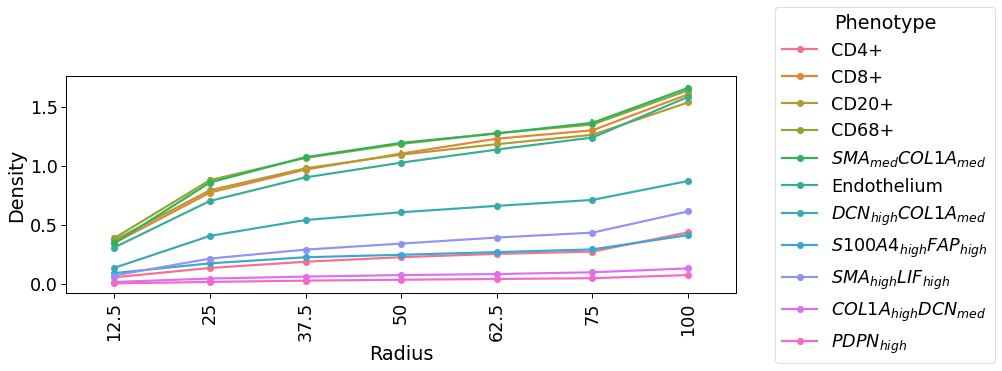

In [95]:
sns.set_context("paper", font_scale=2.0)

fig, ax = plt.subplots(figsize=(12,4))
sns.pointplot(melt_n_df, x = 'distance', y = 'count', hue = 'cell', ax=ax)
ax.set_ylabel('Density')
ax.set_xlabel('Radius')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, bbox_to_anchor=(1.4, 0.5), loc='right', title='Phenotype')

In [31]:
melt_n_df

,core,target_index,target_phenotype,cell_distance,count,cell,distance,core_ID,cons_supercluster
0,12-02-A,566792,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
1,12-02-A,567212,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
2,12-02-A,567307,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
3,12-02-A,567316,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
4,12-02-A,567348,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...
1474930,22-15-I,2659849,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474931,22-15-I,2659914,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474932,22-15-I,2660032,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474933,22-15-I,2660059,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"


In [32]:
pure_cores_filtered[pure_cores_filtered['cons_supercluster'] == 'Hot, discohesive (low risk)']


,core_ID,supercluster,cluster,consensus_HD_equal,consensus_HD_more,cons_supercluster
3,12-02-D,"Hot, discohesive",HPC 10,0,0,"Hot, discohesive (low risk)"
22,12-07-F,"Hot, discohesive",HPC 61,0,0,"Hot, discohesive (low risk)"
23,12-07-G,"Hot, discohesive",NaN,0,0,"Hot, discohesive (low risk)"
32,12-10-F,"Hot, discohesive",HPC 69,0,0,"Hot, discohesive (low risk)"
34,12-10-I,"Hot, discohesive",NaN,0,0,"Hot, discohesive (low risk)"
41,12-12-A,"Hot, discohesive",HPC 28,0,0,"Hot, discohesive (low risk)"
47,12-14-B,"Hot, discohesive",NaN,0,0,"Hot, discohesive (low risk)"
54,12-15-I,"Hot, discohesive",NaN,0,0,"Hot, discohesive (low risk)"
60,13-03-C,"Hot, discohesive",HPC 48,0,0,"Hot, discohesive (low risk)"
65,13-04-A,"Hot, discohesive",NaN,0,0,"Hot, discohesive (low risk)"


/tmp/ipykernel_2086736/3525802538.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);
/tmp/ipykernel_2086736/3525802538.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);
/tmp/ipykernel_2086736/3525802538.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);


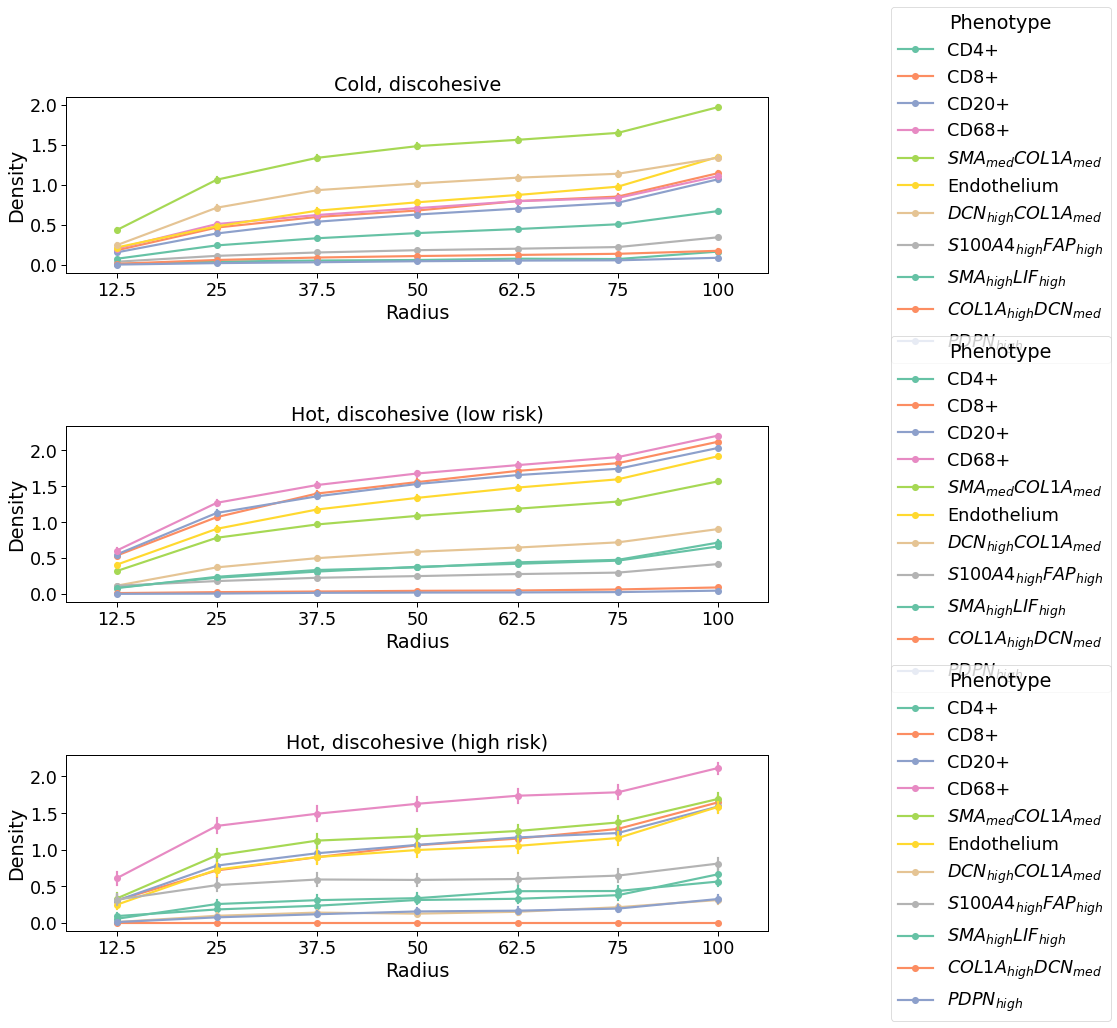

In [96]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18,14))
axs = axs.flatten()

for i, supercluster in enumerate(['Cold, discohesive', 'Hot, discohesive (low risk)', 'Hot, discohesive (high risk)']):
    sns.pointplot(melt_n_df[melt_n_df['cons_supercluster'] == supercluster], x = 'distance', y = 'count', hue = 'cell', palette=sns.color_palette('Set2', n_colors=len(melt_n_df['cell'].unique())), ax=axs[i])
    axs[i].set_ylabel('Density')
    axs[i].set_xlabel('Radius')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);
    axs[i].set_title(supercluster)
    sns.move_legend(axs[i], bbox_to_anchor=(1.5, 0.5), loc='right', title='Phenotype')

plt.tight_layout()

/tmp/ipykernel_2086736/264003353.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);
/tmp/ipykernel_2086736/264003353.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);
/tmp/ipykernel_2086736/264003353.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);


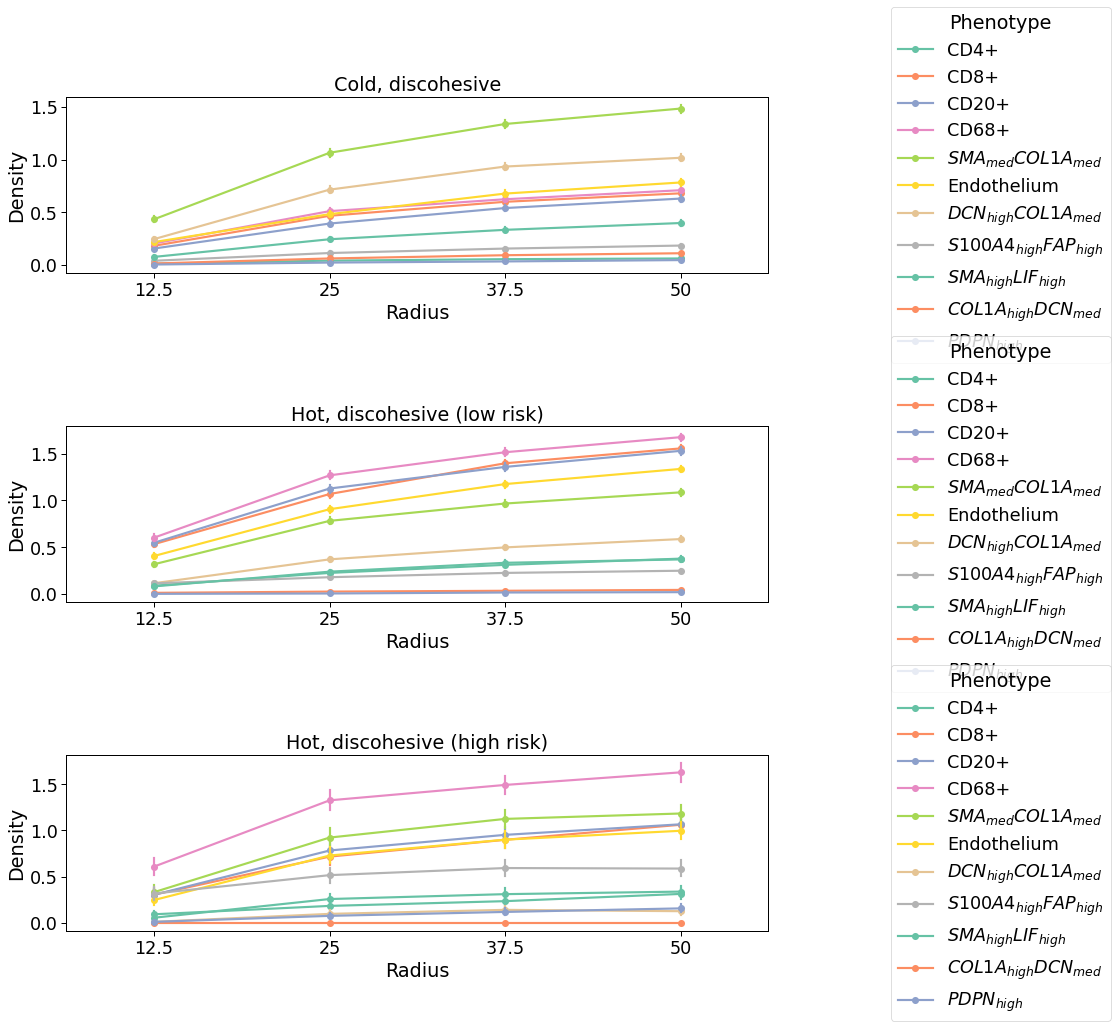

In [97]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18,14))
axs = axs.flatten()

for i, supercluster in enumerate(['Cold, discohesive', 'Hot, discohesive (low risk)', 'Hot, discohesive (high risk)']):
    sns.pointplot(melt_n_df.loc[(melt_n_df['cons_supercluster'] == supercluster) & (melt_n_df['distance'].astype(float) <= 50)], x = 'distance', y = 'count', hue = 'cell', palette=sns.color_palette('Set2', n_colors=len(melt_n_df['cell'].unique())), ax=axs[i])
    axs[i].set_ylabel('Density')
    axs[i].set_xlabel('Radius')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0);
    axs[i].set_title(supercluster)
    sns.move_legend(axs[i], bbox_to_anchor=(1.5, 0.5), loc='right', title='Phenotype')

plt.tight_layout()

/tmp/ipykernel_2086736/1018822008.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0);


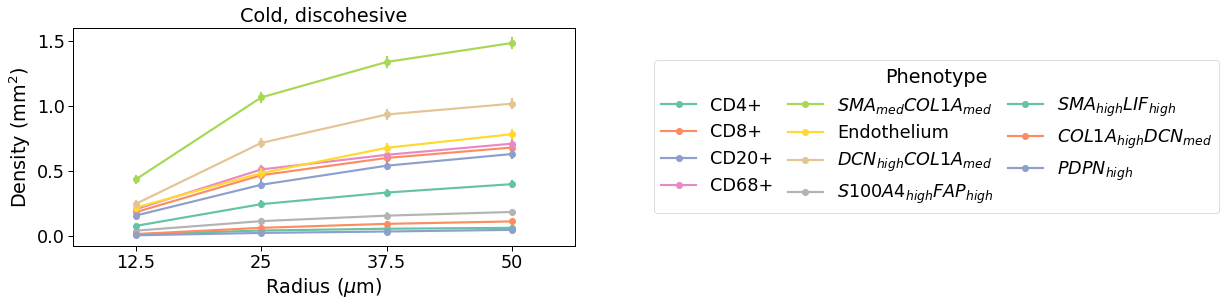

In [98]:
mpl.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(9,4))
supercluster = 'Cold, discohesive'
sns.pointplot(melt_n_df.loc[(melt_n_df['cons_supercluster'] == supercluster) & (melt_n_df['distance'].astype(float) <= 50)], x = 'distance', y = 'count', hue = 'cell', palette=sns.color_palette('Set2', n_colors=len(melt_n_df['cell'].unique())), ax=ax)
ax.set_ylabel(r'Density ($\mathrm{mm^2}$)')
ax.set_xlabel(r'Radius ($\mu$m)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title(supercluster)
sns.move_legend(ax, bbox_to_anchor=(2.3, 0.5), loc='right', ncols=3, title='Phenotype', columnspacing=.8)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/CC_layered_neighbours_legend.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/CC_layered_neighbours_legend.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)



/tmp/ipykernel_2086736/3837044230.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0);


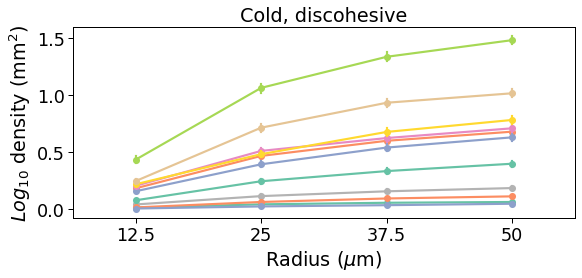

In [196]:
mpl.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(9,3.5))
supercluster = 'Cold, discohesive'
sns.pointplot(melt_n_df.loc[(melt_n_df['cons_supercluster'] == supercluster) & (melt_n_df['distance'].astype(float) <= 50)], x = 'distance', y = 'count', hue = 'cell', palette=sns.color_palette('Set2', n_colors=len(melt_n_df['cell'].unique())), ax=ax)
ax.set_ylabel(r'$Log_{10}$ density ($\mathrm{mm^2}$)')
ax.set_xlabel(r'Radius ($\mu$m)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title(supercluster)
ax.get_legend().remove()
# sns.move_legend(ax, bbox_to_anchor=(1.5, 0.5), loc='right', title='Phenotype')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/CC_layered_neighbours_log.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/CC_layered_neighbours.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)


/tmp/ipykernel_2086736/390285257.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0);


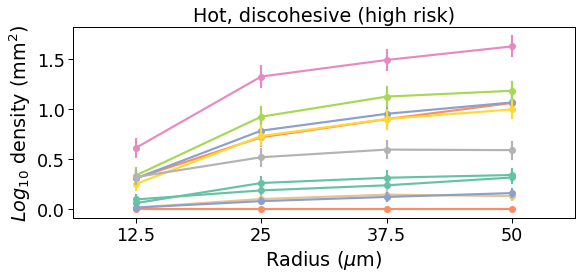

In [195]:
mpl.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(9,3.5))
supercluster = 'Hot, discohesive (high risk)'
sns.pointplot(melt_n_df.loc[(melt_n_df['cons_supercluster'] == supercluster) & (melt_n_df['distance'].astype(float) <= 50)], x = 'distance', y = 'count', hue = 'cell', palette=sns.color_palette('Set2', n_colors=len(melt_n_df['cell'].unique())), ax=ax)
# ax.set_ylabel(r'Density ($\mathrm{mm^2}$)')
ax.set_ylabel(r'$Log_{10}$ density ($\mathrm{mm^2}$)')
ax.set_xlabel(r'Radius ($\mu$m)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title(supercluster)
ax.get_legend().remove()
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/HD_hi_layered_neighbours_log.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/HD_hi_layered_neighbours.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)


/tmp/ipykernel_2086736/3804179472.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0);


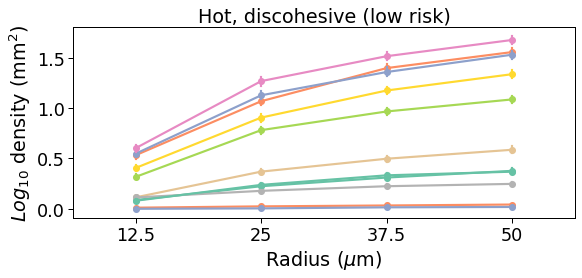

In [194]:
mpl.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(9,3.5))
supercluster = 'Hot, discohesive (low risk)'
sns.pointplot(melt_n_df.loc[(melt_n_df['cons_supercluster'] == supercluster) & (melt_n_df['distance'].astype(float) <= 50)], x = 'distance', y = 'count', hue = 'cell', palette=sns.color_palette('Set2', n_colors=len(melt_n_df['cell'].unique())), ax=ax)
# ax.set_ylabel(r'Density ($\mathrm{mm^2}$)')
ax.set_ylabel(r'$Log_{10}$ density ($\mathrm{mm^2}$)')
ax.set_xlabel(r'Radius ($\mu$m)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title(supercluster)
ax.get_legend().remove()
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/HD_lo_layered_neighbours_log.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/HD_lo_layered_neighbours.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [39]:
melt_n_df

,core,target_index,target_phenotype,cell_distance,count,cell,distance,core_ID,cons_supercluster
0,12-02-A,566792,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
1,12-02-A,567212,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
2,12-02-A,567307,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
3,12-02-A,567316,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
4,12-02-A,567348,Discohesive tumour,CD4+_r12.5,0.0,CD4+,12.5,12-02-A,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...
1474930,22-15-I,2659849,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474931,22-15-I,2659914,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474932,22-15-I,2660032,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"
1474933,22-15-I,2660059,Discohesive tumour,$PDPN_{high}$_r100,0.0,$PDPN_{high}$,100,22-15-I,"Hot, cohesive"


In [ ]:
melt_n_df['cons_supercluster'].value_counts()

Cold, discohesive               431200
Hot, discohesive (low risk)     397474
Hot, cohesive                   308847
Cold, cohesive                  274890
Hot, discohesive (high risk)     62524
Name: cons_supercluster, dtype: int64

#### All cells with a fixed distance

In [58]:
radius = 50

neighbourhood_df_50 = neighbourhood_df.copy(deep=True)
neighbourhood_df_50 = neighbourhood_df_50[['core', 'target_index', 'target_phenotype']+[col for col in neighbourhood_df.columns if str(radius) in col]]
neighbourhood_df_50

,core,target_index,target_phenotype,CD4+_r50,CD8+_r50,CD20+_r50,CD68+_r50,$SMA_{med}COL1A_{med}$_r50,Endothelium_r50,$DCN_{high}COL1A_{med}$_r50,$S100A4_{high}FAP_{high}$_r50,$SMA_{high}LIF_{high}$_r50,$COL1A_{high}DCN_{med}$_r50,$PDPN_{high}$_r50
0,12-02-A,566792,Discohesive tumour,0.0,7.0,2.0,0.0,10.0,1.0,0.0,5.0,0.0,0.0,0.0
1,12-02-A,567212,Discohesive tumour,0.0,8.0,1.0,0.0,12.0,0.0,0.0,9.0,0.0,0.0,0.0
2,12-02-A,567307,Discohesive tumour,0.0,6.0,2.0,1.0,11.0,2.0,0.0,9.0,0.0,0.0,0.0
3,12-02-A,567316,Discohesive tumour,0.0,6.0,2.0,1.0,11.0,1.0,0.0,9.0,0.0,0.0,0.0
4,12-02-A,567348,Discohesive tumour,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,22-15-I,2659849,Discohesive tumour,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,22-15-I,2659914,Discohesive tumour,0.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,22-15-I,2660032,Discohesive tumour,0.0,9.0,7.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
100,22-15-I,2660059,Discohesive tumour,0.0,7.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
columns_list = [col for col in neighbourhood_df.columns if str(radius) in col]

melt_50_df = pd.melt(neighbourhood_df_50, id_vars=['core', 'target_index', 'target_phenotype'], value_vars=columns_list, var_name='cell_distance', value_name='count')
melt_50_df['cell'] = melt_50_df['cell_distance'].apply(lambda x: x.split('_r')[0])
melt_50_df['distance'] = melt_50_df['cell_distance'].apply(lambda x: x.split('_')[-1].replace('r', ''))
melt_50_df['count'] = melt_50_df['count'] / (np.pi * radius ** 2)  * 1000000
melt_50_df['count'] = np.log10(melt_50_df['count'] + 1)
melt_50_df = melt_50_df.merge(pure_clusters_frame[['core_ID', 'cons_supercluster']], left_on='core', right_on='core_ID')

melt_50_df

,core,target_index,target_phenotype,cell_distance,count,cell,distance,core_ID,cons_supercluster
0,12-02-A,566792,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
1,12-02-A,567212,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
2,12-02-A,567307,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
3,12-02-A,567316,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
4,12-02-A,567348,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...
210700,22-15-I,2659849,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"
210701,22-15-I,2659914,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"
210702,22-15-I,2660032,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"
210703,22-15-I,2660059,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"


In [70]:
pivot_50_df = pd.pivot(melt_50_df, index=['core', 'target_index', 'cons_supercluster'], columns='cell', values='count').reset_index()
pivot_50_df

cell,core,target_index,cons_supercluster,$COL1A_{high}DCN_{med}$,$DCN_{high}COL1A_{med}$,$PDPN_{high}$,$S100A4_{high}FAP_{high}$,$SMA_{high}LIF_{high}$,$SMA_{med}COL1A_{med}$,CD20+,CD4+,CD68+,CD8+,Endothelium
0,12-02-A,566792,"Cold, discohesive",0.0,0.0,0.0,2.804562,0.0,3.105251,2.407642,0.0,0.000000,2.950495,2.108308
1,12-02-A,567212,"Cold, discohesive",0.0,0.0,0.0,3.059531,0.0,3.184376,2.108308,0.0,0.000000,3.008426,0.000000
2,12-02-A,567307,"Cold, discohesive",0.0,0.0,0.0,3.059531,0.0,3.146613,2.407642,0.0,2.108308,2.883629,2.407642
3,12-02-A,567316,"Cold, discohesive",0.0,0.0,0.0,3.059531,0.0,3.146613,2.407642,0.0,2.108308,2.883629,2.108308
4,12-02-A,567348,"Cold, discohesive",0.0,0.0,0.0,0.000000,0.0,2.108308,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19150,22-15-I,2659849,"Hot, cohesive",0.0,0.0,0.0,0.000000,0.0,0.000000,2.583167,0.0,0.000000,0.000000,0.000000
19151,22-15-I,2659914,"Hot, cohesive",0.0,0.0,0.0,0.000000,0.0,0.000000,2.407642,0.0,2.108308,2.950495,0.000000
19152,22-15-I,2660032,"Hot, cohesive",0.0,0.0,0.0,2.108308,0.0,0.000000,2.950495,0.0,2.108308,3.059531,2.407642
19153,22-15-I,2660059,"Hot, cohesive",0.0,0.0,0.0,0.000000,0.0,0.000000,2.804562,0.0,0.000000,2.950495,2.583167


### Group by core

In [74]:
core_dict = pure_cores_filtered[['core_ID', 'cons_supercluster']].set_index('core_ID').to_dict()
core_dict

{'cons_supercluster': {'12-02-A': 'Cold, discohesive',
  '12-02-B': 'Hot, cohesive',
  '12-02-C': 'Hot, cohesive',
  '12-02-D': 'Hot, discohesive (low risk)',
  '12-02-F': 'Cold, cohesive',
  '12-02-G': 'Cold, discohesive',
  '12-03-B': 'Hot, cohesive',
  '12-03-C': 'Hot, cohesive',
  '12-03-D': 'Hot, discohesive (high risk)',
  '12-03-F': 'Cold, discohesive',
  '12-03-J': 'Cold, discohesive',
  '12-04-A': 'Cold, discohesive',
  '12-04-C': 'Cold, cohesive',
  '12-04-D': 'Cold, cohesive',
  '12-04-I': 'Cold, cohesive',
  '12-05-J': 'Cold, discohesive',
  '12-06-B': 'Cold, discohesive',
  '12-06-E': 'Hot, cohesive',
  '12-06-G': 'Cold, discohesive',
  '12-06-J': 'Cold, discohesive',
  '12-07-F': 'Hot, discohesive (low risk)',
  '12-07-G': 'Hot, discohesive (low risk)',
  '12-07-J': 'Cold, cohesive',
  '12-08-A': 'Hot, cohesive',
  '12-09-D': 'Cold, discohesive',
  '12-09-E': 'Hot, discohesive (high risk)',
  '12-09-F': 'Cold, discohesive',
  '12-09-H': 'Hot, cohesive',
  '12-10-A': 'Cold

In [75]:
core_dict['cons_supercluster']

{'12-02-A': 'Cold, discohesive',
 '12-02-B': 'Hot, cohesive',
 '12-02-C': 'Hot, cohesive',
 '12-02-D': 'Hot, discohesive (low risk)',
 '12-02-F': 'Cold, cohesive',
 '12-02-G': 'Cold, discohesive',
 '12-03-B': 'Hot, cohesive',
 '12-03-C': 'Hot, cohesive',
 '12-03-D': 'Hot, discohesive (high risk)',
 '12-03-F': 'Cold, discohesive',
 '12-03-J': 'Cold, discohesive',
 '12-04-A': 'Cold, discohesive',
 '12-04-C': 'Cold, cohesive',
 '12-04-D': 'Cold, cohesive',
 '12-04-I': 'Cold, cohesive',
 '12-05-J': 'Cold, discohesive',
 '12-06-B': 'Cold, discohesive',
 '12-06-E': 'Hot, cohesive',
 '12-06-G': 'Cold, discohesive',
 '12-06-J': 'Cold, discohesive',
 '12-07-F': 'Hot, discohesive (low risk)',
 '12-07-G': 'Hot, discohesive (low risk)',
 '12-07-J': 'Cold, cohesive',
 '12-08-A': 'Hot, cohesive',
 '12-09-D': 'Cold, discohesive',
 '12-09-E': 'Hot, discohesive (high risk)',
 '12-09-F': 'Cold, discohesive',
 '12-09-H': 'Hot, cohesive',
 '12-10-A': 'Cold, cohesive',
 '12-10-D': 'Cold, discohesive',
 '12

In [76]:
radius = 50

single_neighbourhood_df = neighbourhood_df[['core', 'target_index', 'target_phenotype']+[col for col in neighbourhood_df.columns if str(radius) in col]]
single_neighbourhood_df

,core,target_index,target_phenotype,CD4+_r50,CD8+_r50,CD20+_r50,CD68+_r50,$SMA_{med}COL1A_{med}$_r50,Endothelium_r50,$DCN_{high}COL1A_{med}$_r50,$S100A4_{high}FAP_{high}$_r50,$SMA_{high}LIF_{high}$_r50,$COL1A_{high}DCN_{med}$_r50,$PDPN_{high}$_r50
0,12-02-A,566792,Discohesive tumour,0.0,7.0,2.0,0.0,10.0,1.0,0.0,5.0,0.0,0.0,0.0
1,12-02-A,567212,Discohesive tumour,0.0,8.0,1.0,0.0,12.0,0.0,0.0,9.0,0.0,0.0,0.0
2,12-02-A,567307,Discohesive tumour,0.0,6.0,2.0,1.0,11.0,2.0,0.0,9.0,0.0,0.0,0.0
3,12-02-A,567316,Discohesive tumour,0.0,6.0,2.0,1.0,11.0,1.0,0.0,9.0,0.0,0.0,0.0
4,12-02-A,567348,Discohesive tumour,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,22-15-I,2659849,Discohesive tumour,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,22-15-I,2659914,Discohesive tumour,0.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,22-15-I,2660032,Discohesive tumour,0.0,9.0,7.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
100,22-15-I,2660059,Discohesive tumour,0.0,7.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [86]:
columns_list = [col for col in neighbourhood_df.columns if str(radius) in col]

melt_raw_n_df = pd.melt(single_neighbourhood_df, id_vars=['core', 'target_index', 'target_phenotype'], value_vars=columns_list, var_name='cell_distance', value_name='count')
melt_raw_n_df['cell'] = melt_raw_n_df['cell_distance'].apply(lambda x: x.split('_r')[0])
melt_raw_n_df['distance'] = melt_raw_n_df['cell_distance'].apply(lambda x: x.split('_')[-1].replace('r', ''))
melt_raw_n_df['count'] = melt_raw_n_df['count'] / (np.pi * radius ** 2)  * 1000000
melt_raw_n_df = melt_raw_n_df.merge(pure_clusters_frame[['core_ID', 'cons_supercluster']], left_on='core', right_on='core_ID')

melt_raw_n_df

,core,target_index,target_phenotype,cell_distance,count,cell,distance,core_ID,cons_supercluster
0,12-02-A,566792,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
1,12-02-A,567212,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
2,12-02-A,567307,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
3,12-02-A,567316,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
4,12-02-A,567348,Discohesive tumour,CD4+_r50,0.0,CD4+,50,12-02-A,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...
210700,22-15-I,2659849,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"
210701,22-15-I,2659914,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"
210702,22-15-I,2660032,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"
210703,22-15-I,2660059,Discohesive tumour,$PDPN_{high}$_r50,0.0,$PDPN_{high}$,50,22-15-I,"Hot, cohesive"


In [99]:
grouped_df = melt_raw_n_df.groupby(['core', 'cell', 'distance']).agg('mean').reset_index()
grouped_df['supercluster'] = grouped_df['core'].map(core_dict['cons_supercluster'])
grouped_df = grouped_df[grouped_df['supercluster'].isin(['Cold, discohesive', 'Hot, discohesive (low risk)', 'Hot, discohesive (high risk)'])]
grouped_df = grouped_df.replace({
    'Hot, discohesive (low risk)':'Hot, discohesive\n(low risk)',
    'Hot, discohesive (high risk)':'Hot, discohesive\n(high risk)'
})
grouped_df['count'] = np.log10(grouped_df['count']+ 1)


grouped_df

/tmp/ipykernel_2086736/3461891839.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = melt_raw_n_df.groupby(['core', 'cell', 'distance']).agg('mean').reset_index()


,core,cell,distance,count,supercluster
0,12-02-A,$COL1A_{high}DCN_{med}$,50,0.757070,"Cold, discohesive"
1,12-02-A,$DCN_{high}COL1A_{med}$,50,1.132746,"Cold, discohesive"
2,12-02-A,$PDPN_{high}$,50,0.000000,"Cold, discohesive"
3,12-02-A,$S100A4_{high}FAP_{high}$,50,2.338302,"Cold, discohesive"
4,12-02-A,$SMA_{high}LIF_{high}$,50,0.000000,"Cold, discohesive"
...,...,...,...,...,...
2151,22-14-H,CD20+,50,2.222654,"Hot, discohesive\n(low risk)"
2152,22-14-H,CD4+,50,1.375415,"Hot, discohesive\n(low risk)"
2153,22-14-H,CD68+,50,3.730450,"Hot, discohesive\n(low risk)"
2154,22-14-H,CD8+,50,3.501122,"Hot, discohesive\n(low risk)"


In [103]:
grouped_df

,core,cell,distance,count,supercluster
0,12-02-A,$COL1A_{high}DCN_{med}$,50,0.757070,"Cold, discohesive"
1,12-02-A,$DCN_{high}COL1A_{med}$,50,1.132746,"Cold, discohesive"
2,12-02-A,$PDPN_{high}$,50,0.000000,"Cold, discohesive"
3,12-02-A,$S100A4_{high}FAP_{high}$,50,2.338302,"Cold, discohesive"
4,12-02-A,$SMA_{high}LIF_{high}$,50,0.000000,"Cold, discohesive"
...,...,...,...,...,...
2151,22-14-H,CD20+,50,2.222654,"Hot, discohesive\n(low risk)"
2152,22-14-H,CD4+,50,1.375415,"Hot, discohesive\n(low risk)"
2153,22-14-H,CD68+,50,3.730450,"Hot, discohesive\n(low risk)"
2154,22-14-H,CD8+,50,3.501122,"Hot, discohesive\n(low risk)"


/tmp/ipykernel_2086736/4232283703.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/4232283703.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/4232283703.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/4232283703.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/4232283703.py:8: UserWarning: set_ticklabels() sh

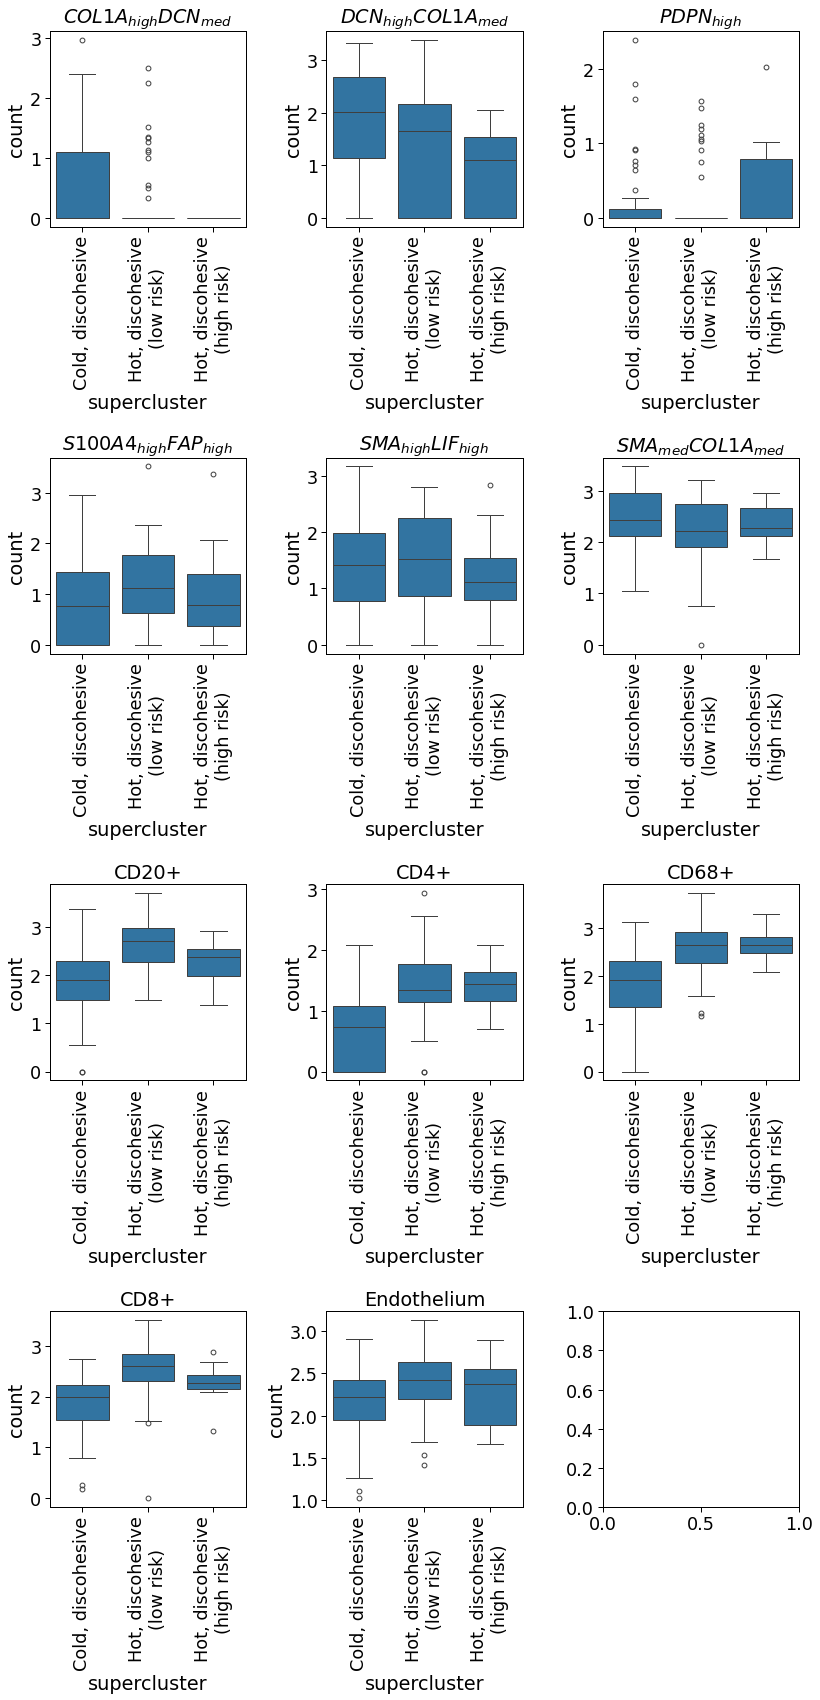

In [104]:
phenotypes = grouped_df['cell'].unique()

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12,24))
axs = axs.flatten()

for i, phenotype in enumerate(phenotypes):
    sns.boxplot(grouped_df[grouped_df['cell'] == phenotype], x='supercluster', y='count', ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_title(phenotype)

plt.tight_layout()
plt.show()

In [123]:
def enrichment_test_by_phenotype(data, phenotype_cols, meta_col, p_th=0.05):
    results = list()
    overall_avg = data.mean(numeric_only=True, axis=0)

    for group in data[meta_col].unique():
        for phenotype in phenotype_cols:
            positive_group = data[data[meta_col] == group][phenotype].values
            negative_group = data[data[meta_col] != group][phenotype].values
            statistic, p_value = stats.mannwhitneyu(positive_group, negative_group, alternative='two-sided')
            # relative_change = np.mean(positive_group)
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            relative_change = np.mean(positive_group) - overall_avg.loc[phenotype]

            results.append({
                'Supercluster':group,
                'marker':phenotype,
                'relative change':relative_change,
                'statistic':statistic,
                'p_val': p_value
            })

    results = pd.DataFrame(results)

    results['p_adj'] = stats.false_discovery_control(results['p_val'], method='bh')
    change_data = results.pivot(index='Supercluster', columns='marker', values='relative change')
    pval_data = results.pivot(index='Supercluster', columns='marker', values='p_adj')

    significant_mask = pval_data < p_th
    annot_text = change_data.applymap('{:.2f}'.format)
    annot_text = annot_text.mask(significant_mask, '*')
    annot_text = annot_text.mask(~significant_mask, ' ')

    return change_data, annot_text, results

In [124]:
grouped_df_pivot = pd.pivot(grouped_df.drop(labels='distance', axis=1), index=['core', 'supercluster'], columns='cell', values='count').reset_index()
# grouped_df_pivot = grouped_df_pivot.groupby('supercluster').agg('median')
grouped_df_pivot

cell,core,supercluster,$COL1A_{high}DCN_{med}$,$DCN_{high}COL1A_{med}$,$PDPN_{high}$,$S100A4_{high}FAP_{high}$,$SMA_{high}LIF_{high}$,$SMA_{med}COL1A_{med}$,CD20+,CD4+,CD68+,CD8+,Endothelium
0,12-02-A,"Cold, discohesive",0.75707,1.132746,0.000000,2.338302,0.000000,2.784849,1.682660,0.000000,1.805338,2.570506,2.102955
1,12-02-D,"Hot, discohesive\n(low risk)",0.00000,0.000000,0.000000,3.520598,1.382914,3.021501,1.869296,1.735780,2.673951,2.407642,2.698632
2,12-02-G,"Cold, discohesive",0.00000,2.010043,0.000000,0.899229,2.165876,2.429171,3.382910,1.320591,2.474346,2.158105,2.657880
3,12-03-D,"Hot, discohesive\n(high risk)",0.00000,0.000000,0.000000,3.367240,1.145140,2.953925,1.516284,1.390556,2.793995,2.087885,2.499375
4,12-03-F,"Cold, discohesive",0.00000,0.854104,0.273718,0.000000,0.000000,1.801711,1.513370,0.731628,2.206323,1.476791,1.729859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,22-11-J,"Hot, discohesive\n(low risk)",0.00000,0.000000,0.000000,1.950108,1.653923,2.016359,3.340443,0.770637,2.962252,2.304878,2.454891
97,22-13-E,"Hot, discohesive\n(low risk)",0.00000,2.041925,1.478604,1.888709,1.963531,2.858110,2.685590,1.191767,2.994252,2.866784,2.655225
98,22-13-H,"Hot, discohesive\n(low risk)",0.00000,0.000000,0.000000,1.490781,2.116676,2.082190,2.597097,1.321648,3.638488,3.270312,2.705692
99,22-14-A,"Cold, discohesive",0.00000,2.220645,0.000000,2.129166,3.162303,3.077102,1.891065,1.134406,2.017542,2.171191,2.220645


In [126]:
grouped_df_pivot

cell,core,supercluster,$COL1A_{high}DCN_{med}$,$DCN_{high}COL1A_{med}$,$PDPN_{high}$,$S100A4_{high}FAP_{high}$,$SMA_{high}LIF_{high}$,$SMA_{med}COL1A_{med}$,CD20+,CD4+,CD68+,CD8+,Endothelium
0,12-02-A,"Cold, discohesive",0.75707,1.132746,0.000000,2.338302,0.000000,2.784849,1.682660,0.000000,1.805338,2.570506,2.102955
1,12-02-D,"Hot, discohesive\n(low risk)",0.00000,0.000000,0.000000,3.520598,1.382914,3.021501,1.869296,1.735780,2.673951,2.407642,2.698632
2,12-02-G,"Cold, discohesive",0.00000,2.010043,0.000000,0.899229,2.165876,2.429171,3.382910,1.320591,2.474346,2.158105,2.657880
3,12-03-D,"Hot, discohesive\n(high risk)",0.00000,0.000000,0.000000,3.367240,1.145140,2.953925,1.516284,1.390556,2.793995,2.087885,2.499375
4,12-03-F,"Cold, discohesive",0.00000,0.854104,0.273718,0.000000,0.000000,1.801711,1.513370,0.731628,2.206323,1.476791,1.729859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,22-11-J,"Hot, discohesive\n(low risk)",0.00000,0.000000,0.000000,1.950108,1.653923,2.016359,3.340443,0.770637,2.962252,2.304878,2.454891
97,22-13-E,"Hot, discohesive\n(low risk)",0.00000,2.041925,1.478604,1.888709,1.963531,2.858110,2.685590,1.191767,2.994252,2.866784,2.655225
98,22-13-H,"Hot, discohesive\n(low risk)",0.00000,0.000000,0.000000,1.490781,2.116676,2.082190,2.597097,1.321648,3.638488,3.270312,2.705692
99,22-14-A,"Cold, discohesive",0.00000,2.220645,0.000000,2.129166,3.162303,3.077102,1.891065,1.134406,2.017542,2.171191,2.220645


In [197]:
grouped_df_pivot['supercluster'].value_counts()

Hot, discohesive\n(low risk)     50
Cold, discohesive                43
Hot, discohesive\n(high risk)     8
Name: supercluster, dtype: int64

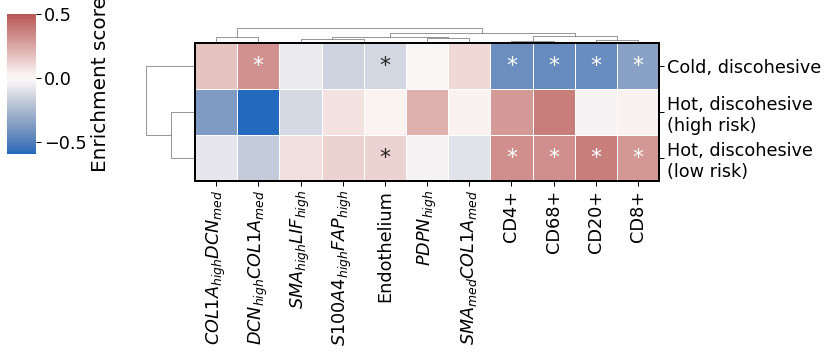

In [202]:
change_data, annot_text, results = enrichment_test_by_phenotype(grouped_df_pivot, phenotype_cols=[col.split('_r50')[0] for col in columns_list], meta_col='supercluster', p_th=0.05)

from matplotlib.patches import Rectangle
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

change_data.columns.name = ""
change_data.index.name = ""

g = sns.clustermap(change_data,
               cmap='vlag',
            #    vmin=-0.5,
            vmax=0.5,
            center=0,
               linewidth=.5,
               cbar_kws={'label':'Enrichment score'},
               cbar_pos=(-.16, .59, .04, .39),
               dendrogram_ratio=(.1, .1),
               annot=annot_text,
               annot_kws={'fontsize':'22'},
               fmt='',
               figsize=(10,5))

g.ax_heatmap.collections[0].colorbar.set_label("Enrichment score", fontsize=20)
g.ax_heatmap.collections[0].set_linewidth(.5)

n_rows, n_cols = change_data.shape

rect = Rectangle(
    xy=(0, 0),  # Lower left corner
    width=n_cols,
    height=n_rows,
    fill=False,
    edgecolor='black',
    linewidth=2,
    clip_on=False
)
g.ax_heatmap.add_patch(rect)

plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/layered_n50_heatmap.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [135]:
hot_only = grouped_df_pivot[grouped_df_pivot['supercluster'] != 'Cold, discohesive']

In [157]:
hot_only

cell,core,supercluster,$COL1A_{high}DCN_{med}$,$DCN_{high}COL1A_{med}$,$PDPN_{high}$,$S100A4_{high}FAP_{high}$,$SMA_{high}LIF_{high}$,$SMA_{med}COL1A_{med}$,CD20+,CD4+,CD68+,CD8+,Endothelium
1,12-02-D,"Hot, discohesive\n(low risk)",0.000000,0.000000,0.000000,3.520598,1.382914,3.021501,1.869296,1.735780,2.673951,2.407642,2.698632
3,12-03-D,"Hot, discohesive\n(high risk)",0.000000,0.000000,0.000000,3.367240,1.145140,2.953925,1.516284,1.390556,2.793995,2.087885,2.499375
11,12-07-F,"Hot, discohesive\n(low risk)",0.000000,0.000000,0.000000,1.237982,2.444134,2.670741,2.603476,1.499106,2.621823,2.045354,2.373454
12,12-07-G,"Hot, discohesive\n(low risk)",0.000000,3.053252,1.116403,0.731628,2.352018,2.192468,3.092342,1.652293,2.837658,2.837658,2.431230
14,12-09-E,"Hot, discohesive\n(high risk)",0.000000,1.333804,0.000000,1.167666,0.837367,1.663259,2.341256,2.080946,2.602712,2.337361,1.920493
17,12-10-F,"Hot, discohesive\n(low risk)",0.000000,2.860431,0.000000,0.697131,2.283269,2.065906,2.767819,0.952199,2.482008,2.342103,2.569415
18,12-10-I,"Hot, discohesive\n(low risk)",0.000000,0.000000,0.545675,0.886562,2.188342,2.892107,2.751851,2.381242,2.275623,2.842769,2.784717
20,12-11-F,"Hot, discohesive\n(high risk)",0.000000,0.862585,1.018343,1.018343,1.298041,2.319087,2.917110,1.298041,2.653756,2.866333,2.443505
24,12-14-B,"Hot, discohesive\n(low risk)",0.000000,1.880986,0.000000,0.000000,0.893258,1.451536,2.631895,1.004088,1.165596,2.216699,1.415141
25,12-14-C,"Hot, discohesive\n(high risk)",0.000000,0.000000,2.028638,2.059030,0.647499,2.081280,2.147268,1.480727,2.081280,2.246746,1.660253


/tmp/ipykernel_2086736/2039108930.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/2039108930.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/2039108930.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2086736/2039108930.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


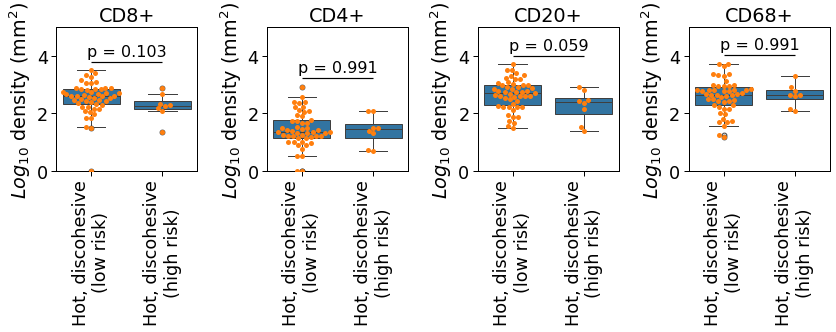

In [189]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,5))
axs = axs.flatten()

for i, cell in enumerate(['CD8+', 'CD4+', 'CD20+', 'CD68+']):
    stat, pval = stats.mannwhitneyu(hot_only[hot_only['supercluster'] == 'Hot, discohesive\n(low risk)'][cell].values, 
                                    hot_only[hot_only['supercluster'] == 'Hot, discohesive\n(high risk)'][cell].values)
    sns.boxplot(hot_only, x='supercluster', y=cell, ax=axs[i])
    sns.swarmplot(hot_only, x='supercluster', y=cell, ax=axs[i])
    axs[i].set_ylim([0,5])
    axs[i].hlines(hot_only[cell].max() + 0.3, xmin=0, xmax=1, color='black')
    axs[i].text(s=f'p = {pval:.3f}', y=hot_only[cell].max() + 0.5, x=-0.05, size=16)
    axs[i].set_ylabel(r'$Log_{10}$ density (mm$^2$)')
    axs[i].set_xlabel(None)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_title(cell)

plt.tight_layout()
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/layered_n50_inflam_box_plot.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()